# WeGo Public Transit
[WeGo Public Transit](https://www.wegotransit.com/) is a public transit system serving the Greater Nashville and Davidson County area. WeGo provides local and regional bus routes, the WeGo Star train service connecting Lebanon to downtown Nashville, along with several other transit services.

The data for this project can be downloaded from [here](https://drive.google.com/file/d/1iM4WjC9k3EXHPNc6q4AwDh_MEIpXvfMD/view?usp=sharing).

In this project, you'll be analyzing the bus spacing to look for patterns and try to identify correlations to controllable or external factors. Specifically, you'll be using a dataset containing information on the headway, or amount of time between vehicle arrivals at a stop. 

There are two main variables you will be studying in this project, headway deviation and adherence.

**Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

Another important variable is **adherence**, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. **Note:** When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
wego = pd.read_csv(r'C:\Users\jenni\OneDrive\Desktop\DA12\Projects\Python\wego-python-da12-python-spice-lattes\data\Headway Data, 8-1-2023 to 9-30-2023.csv')

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [4]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                350329 non-null  int64  
 1   SERVICE_ABBR               350329 non-null  int64  
 2   ADHERENCE_ID               350329 non-null  int64  
 3   DATE                       350329 non-null  object 
 4   ROUTE_ABBR                 350329 non-null  int64  
 5   BLOCK_ABBR                 350329 non-null  int64  
 6   OPERATOR                   350329 non-null  int64  
 7   TRIP_ID                    350329 non-null  int64  
 8   OVERLOAD_ID                350329 non-null  int64  
 9   ROUTE_DIRECTION_NAME       350329 non-null  object 
 10  TIME_POINT_ABBR            350329 non-null  object 
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64
 12  TRIP_EDGE                  350329 non-null  int64  
 13  LATITUDE                   35

Goals of this project:


1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

**2. How does direction of travel, route, or location affect the headway and on-time performance?**

NOTE TO SELF: possible layered histogram for looking at the diff factors

NOTE TO SELF 2: want to see each factor individually AND how they may layer 

*Investigate adherence first (ie. on-time performance - actual departure time v scheduled departure time)

In [11]:
#group the dataset by route FIRST - see each bus route and the mean adherence for it

In [12]:
routes_adherence_df = wego.groupby(['ROUTE_ABBR']).mean(['ADHERENCE'])
routes_adherence_df.head(20)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
ROUTE_ABBR,,,,,,,,,,,,,,,,,,,,,
3,1.202309e+08,1.317798,1.001026e+08,307.618464,1967.163988,350813.375175,0.007103,4.445549,0.545333,36.133861,...,20.133135,0.580907,0.029303,0.203342,0.731860,0.015351,0.012573,0.010602,2.522974,13.336085
7,1.202309e+08,1.313547,1.001076e+08,739.209753,1967.504937,353122.552757,0.003606,3.993565,0.999501,36.137767,...,23.161475,0.336808,0.024021,0.189560,0.744314,0.019361,0.016894,0.015977,4.099449,12.413610
22,1.202309e+08,1.275280,1.001001e+08,2220.916522,1951.857121,349844.198428,0.003082,5.862475,0.881968,36.182597,...,30.600886,0.955867,0.024308,0.079549,0.866443,0.050156,0.066419,0.012982,3.482251,8.801047
23,1.202309e+08,1.297924,1.001005e+08,2308.833286,1827.335851,350148.296594,0.002541,4.198114,0.615061,36.206481,...,19.275453,1.053563,0.030541,0.076708,0.834450,0.017051,0.017331,0.010734,3.152254,9.631453
50,1.202309e+08,1.330554,1.001052e+08,5022.724770,1758.862697,351549.750780,0.006814,14.421658,0.509505,36.149227,...,19.753606,0.212376,0.027881,0.118108,0.838719,0.008547,0.008156,0.010949,2.881760,12.788249
52,1.202309e+08,1.305602,1.001041e+08,5208.012872,2054.115633,351885.109651,0.008491,5.250796,0.515660,36.108850,...,20.849976,0.974776,0.029970,0.193713,0.728227,0.011405,0.011003,0.012177,3.066427,14.638789
55,1.202309e+08,1.286711,1.001050e+08,5510.517500,1990.542345,352277.852108,0.008314,8.137883,0.506942,36.112883,...,13.858523,0.261038,0.024716,0.270373,0.679323,0.010493,0.010126,0.011849,2.412738,13.713638
56,1.202309e+08,1.271976,1.001052e+08,5603.721226,2029.239503,352686.363712,0.008097,9.401300,0.502532,36.236244,...,14.158662,0.149213,0.029190,0.147234,0.805748,0.010713,0.010571,0.012862,3.161385,14.529440


In [13]:
# routes_adherence_df.info() #see what columns I have

In [14]:
routes_adherence_df = routes_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
routes_adherence_df.head(20)

,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
ROUTE_ABBR,,,,,,,
3,-3.761491,19.523403,20.133135,0.580907,0.029303,0.203342,0.731860
7,-3.346555,22.785186,23.161475,0.336808,0.024021,0.189560,0.744314
22,-1.138107,29.992722,30.600886,0.955867,0.024308,0.079549,0.866443
23,-1.760110,18.373912,19.275453,1.053563,0.030541,0.076708,0.834450
50,-2.505022,19.528756,19.753606,0.212376,0.027881,0.118108,0.838719
52,-3.971342,19.980827,20.849976,0.974776,0.029970,0.193713,0.728227
55,-4.823302,13.581157,13.858523,0.261038,0.024716,0.270373,0.679323
56,-2.703988,13.983759,14.158662,0.149213,0.029190,0.147234,0.805748


Observe above that all routes fall within the bucket of 'on time' (-6 - 1) for avg adherence, though some routes are more on time than others. Plot later.

In [16]:
#group the dataset by route direction next 
direction_adherence_df = wego.groupby(['ROUTE_DIRECTION_NAME']).mean(['ADHERENCE'])
direction_adherence_df.head(20)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,TRIP_EDGE,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
ROUTE_DIRECTION_NAME,,,,,,,,,,,,,,,,,,,,,
FROM DOWNTOWN,1.202309e+08,1.302261,1.001038e+08,38.444296,3853.224131,1977.008461,351605.289672,0.007702,7.585649,0.546059,...,18.185985,0.579990,0.028478,0.213146,0.723461,0.012670,0.013194,0.019942,2.493444,9.341724
TO DOWNTOWN,1.202309e+08,1.294179,1.001038e+08,38.239334,3839.862346,1921.909303,351614.877905,0.005421,7.086656,0.616388,...,19.174063,0.447773,0.027252,0.118132,0.824342,0.018191,0.017476,0.002936,3.492617,15.931242


In [17]:
direction_adherence_df = direction_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
direction_adherence_df.head()

,ROUTE_ABBR,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
ROUTE_DIRECTION_NAME,,,,,,,,
FROM DOWNTOWN,38.444296,-3.960287,17.673479,18.185985,0.579990,0.028478,0.213146,0.723461
TO DOWNTOWN,38.239334,-2.321804,18.772306,19.174063,0.447773,0.027252,0.118132,0.824342


Observe above that 'FROM DOWNTOWN' is generally less on time than toward downtown. May not need a plot here

In [19]:
#group the dataset by location next - location defined by block_abbr (the section/block of the route that the given stop is on)
block_adherence_df = wego.groupby(['BLOCK_ABBR']).mean(['ADHERENCE'])
block_adherence_df.head(20)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,ROUTE_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
BLOCK_ABBR,,,,,,,,,,,,,,,,,,,,,
300,1.202309e+08,1.451765,1.001059e+08,3.000000,2235.182145,350670.824376,0.008995,4.040926,0.591747,36.146048,...,22.290352,0.322731,0.034630,0.217675,0.711716,0.018327,0.011631,0.014392,2.105501,12.161010
301,1.202309e+08,1.500168,1.001052e+08,3.000000,2161.809195,350756.834119,0.011283,4.037386,0.594308,36.145802,...,17.416645,0.108538,0.029808,0.152745,0.788313,0.018188,0.013658,0.010273,2.261899,10.636161
302,1.202309e+08,1.000000,1.000935e+08,3.000000,1314.802326,350695.453488,0.000000,4.000000,0.600000,36.146895,...,14.496040,0.514990,0.008140,0.160465,0.829070,0.004651,0.011628,0.002326,2.723271,8.196581
303,1.202309e+08,1.000000,1.000934e+08,3.000000,1187.798227,350711.337830,0.005589,4.000385,0.599345,36.146891,...,20.713154,2.249422,0.013297,0.304490,0.659665,0.010407,0.006745,0.010214,2.372611,12.862884
304,1.202309e+08,1.000000,1.000914e+08,3.000000,2610.632184,350727.316092,0.028736,4.000000,0.597701,36.146895,...,11.380115,0.619389,0.033333,0.245977,0.591954,0.044828,0.025862,0.000000,2.479331,10.729167
305,1.202309e+08,1.000000,1.000935e+08,3.000000,2378.406395,350730.318205,0.002063,4.553378,0.533265,36.130587,...,20.369663,0.847533,0.042806,0.258896,0.600309,0.015988,0.011920,0.000000,2.358481,14.637555
310,1.202309e+08,1.974650,1.001217e+08,3.000000,1858.370580,350969.460307,0.007338,4.831554,0.498999,36.122417,...,26.569611,2.034319,0.022682,0.215811,0.726818,0.020680,0.018014,0.006004,3.013574,15.794721
311,1.202309e+08,1.402082,1.001060e+08,3.000000,1817.211362,350878.917784,0.004940,4.834333,0.499471,36.122370,...,21.745388,0.567716,0.012174,0.188250,0.773994,0.012174,0.010375,0.011291,2.570303,14.765873
312,1.202309e+08,2.141983,1.001243e+08,3.000000,2181.102407,351099.537332,0.000000,4.818033,0.501836,36.122836,...,26.192634,1.393152,0.013872,0.124847,0.820481,0.015504,0.013229,0.011424,2.884241,13.843137


In [20]:
# block_adherence_df.info()

In [21]:
block_adherence_df = block_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
block_adherence_df.head(20)

,ROUTE_ABBR,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
BLOCK_ABBR,,,,,,,,
300,3.000000,-3.850305,21.856318,22.290352,0.322731,0.034630,0.217675,0.711716
301,3.000000,-3.057959,17.233663,17.416645,0.108538,0.029808,0.152745,0.788313
302,3.000000,-2.877253,14.000000,14.496040,0.514990,0.008140,0.160465,0.829070
303,3.000000,-5.213002,18.503252,20.713154,2.249422,0.013297,0.304490,0.659665
304,3.000000,-5.175286,10.751437,11.380115,0.619389,0.033333,0.245977,0.591954
305,3.000000,-4.600533,19.406897,20.369663,0.847533,0.042806,0.258896,0.600309
310,3.000000,-3.957469,24.430098,26.569611,2.034319,0.022682,0.215811,0.726818
311,3.000000,-3.699363,21.223587,21.745388,0.567716,0.012174,0.188250,0.773994
312,3.000000,-2.837090,24.921549,26.192634,1.393152,0.013872,0.124847,0.820481


Observe that some blocks are more late than others, with only one block falling outside the accepted zone 

In [23]:
#group the dataset by route AND route direction - see each bus route and its to/from downtown direction
#take the mean adherence to see if we can get a summary per route and direction combo
route_v_dir_adherence_df = wego.groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).mean(['ADHERENCE'])
route_v_dir_adherence_df.head(20)

CALENDAR_ID  SERVICE_ABBR  ADHERENCE_ID  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                             
3          FROM DOWNTOWN         1.202309e+08      1.317378  1.001027e+08   
           TO DOWNTOWN           1.202309e+08      1.318220  1.001025e+08   
7          FROM DOWNTOWN         1.202309e+08      1.309454  1.001071e+08   
           TO DOWNTOWN           1.202309e+08      1.317787  1.001081e+08   
22         FROM DOWNTOWN         1.202309e+08      1.282716  1.001000e+08   
           TO DOWNTOWN           1.202309e+08      1.267361  1.001002e+08   
23         FROM DOWNTOWN         1.202309e+08      1.319882  1.001010e+08   
           TO DOWNTOWN           1.202309e+08      1.264792  1.000996e+08   
50         FROM DOWNTOWN         1.202309e+08      1.331727  1.001049e+08   
           TO DOWNTOWN           1.202309e+08      1.329388  1.001056e+08   
52         FROM DOWNTOWN         1.202309e+08      1.307581  1.001047e+08   
           TO DOWNTOWN           1.202309e+08      1.303458  1.001035e+08   
55         FROM DOWNTOWN         1.202309e+08      1.290132  1.001047e+08   
           TO DOWNTOWN           1.202309e+08      1.283345  1.001053e+08   
56         FROM DOWNTOWN         1.202309e+08      1.273283  1.001050e+08   
           TO DOWNTOWN           1.202309e+08      1.270146  1.001054e+08   

                                  BLOCK_ABBR     OPERATOR        TRIP_ID  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                            
3          FROM DOWNTOWN          307.911501  1983.260888  350814.314757   
           TO DOWNTOWN            307.323707  1950.972610  350812.430078   
7          FROM DOWNTOWN          702.291680  1988.000763  353147.774179   
           TO DOWNTOWN            777.445285  1946.277696  353096.431282   
22         FROM DOWNTOWN         2203.612115  1977.400060  349834.570063   
           TO DOWNTOWN           2239.345557  1924.654125  349854.452550   
23         FROM DOWNTOWN         2309.249872  1855.812280  350160.439171   
           TO DOWNTOWN           2308.204671  1784.365846  350129.973843   
50         FROM DOWNTOWN         5027.125869  1753.479980  351549.450737   
           TO DOWNTOWN           5018.351034  1764.211947  351550.048957   
52         FROM DOWNTOWN         5208.139003  2096.442317  351888.913318   
           TO DOWNTOWN           5207.876196  2008.250663  351880.988018   
55         FROM DOWNTOWN         5505.248201  2039.445942  352273.866230   
           TO DOWNTOWN           5515.700740  1942.437442  352281.772889   
56         FROM DOWNTOWN         5605.065429  2048.467914  352687.183636   
           TO DOWNTOWN           5601.838912  2002.313577  352685.215557   

                                 OVERLOAD_ID  ROUTE_STOP_SEQUENCE  TRIP_EDGE  \
ROUTE_ABBR ROUTE_DIRECTION_NAME                                                
3          FROM DOWNTOWN            0.008372             4.455603   0.543552   
           TO DOWNTOWN              0.005827             4.435437   0.547125   
7          FROM DOWNTOWN            0.004034             4.000000   0.998910   
           TO DOWNTOWN              0.003162             3.986900   1.000113   
22         FROM DOWNTOWN            0.002689             6.285405   0.850911   
           TO DOWNTOWN              0.003500             5.412060   0.915043   
23         FROM DOWNTOWN            0.002843             4.660836   0.525765   
           TO DOWNTOWN              0.002085             3.499911   0.749806   
50         FROM DOWNTOWN            0.007878            14.462879   0.506025   
           TO DOWNTOWN              0.005757            14.380694   0.512965   
52         FROM DOWNTOWN            0.011281             5.843816   0.496271   
           TO DOWNTOWN              0.005468             4.608203   0.536671   
55         FROM DOWNTOWN            0.008888             8.160725   0.501156   
           TO DOWNTOWN              0.007750             8.115413   0.512633  

In [24]:
route_v_dir_adherence_df.info() #see what columns i currently have

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16 entries, (3, 'FROM DOWNTOWN') to (56, 'TO DOWNTOWN')
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CALENDAR_ID                16 non-null     float64
 1   SERVICE_ABBR               16 non-null     float64
 2   ADHERENCE_ID               16 non-null     float64
 3   BLOCK_ABBR                 16 non-null     float64
 4   OPERATOR                   16 non-null     float64
 5   TRIP_ID                    16 non-null     float64
 6   OVERLOAD_ID                16 non-null     float64
 7   ROUTE_STOP_SEQUENCE        16 non-null     float64
 8   TRIP_EDGE                  16 non-null     float64
 9   LATITUDE                   16 non-null     float64
 10  LONGITUDE                  16 non-null     float64
 11  ADHERENCE                  16 non-null     float64
 12  SCHEDULED_HDWY             16 non-null     float64
 13  ACTUAL_HDWY     

In [25]:
route_v_dir_adherence_df = route_v_dir_adherence_df[['ADHERENCE']]
route_v_dir_adherence_df.head(20)

ADHERENCE
ROUTE_ABBR ROUTE_DIRECTION_NAME           
3          FROM DOWNTOWN         -4.831550
           TO DOWNTOWN           -2.689360
7          FROM DOWNTOWN         -4.028927
           TO DOWNTOWN           -2.599183
22         FROM DOWNTOWN         -2.179503
           TO DOWNTOWN           -0.041538
23         FROM DOWNTOWN         -2.295042
           TO DOWNTOWN           -0.959462
50         FROM DOWNTOWN         -2.729163
           TO DOWNTOWN           -2.282192
52         FROM DOWNTOWN         -5.149382
           TO DOWNTOWN           -2.723518
55         FROM DOWNTOWN         -5.673887
           TO DOWNTOWN           -3.989490
56         FROM DOWNTOWN         -3.579404
           TO DOWNTOWN           -1.484165

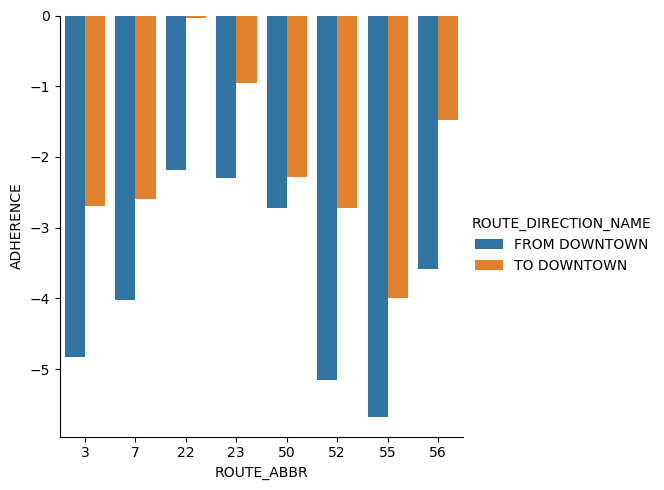

In [26]:
sns.catplot(x='ROUTE_ABBR', y='ADHERENCE', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_adherence_df, kind='bar')
plt.show()

In [27]:
route_v_dir_adherence_df = route_v_dir_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWAY_DEV', '', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
route_v_dir_adherence_df.head(20)

KeyError: "['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWAY_DEV', '', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'] not found in axis"

In [ ]:
# maybe split the direction column into 2 first?


In [ ]:
# plt.bar(data=route_v_dir_adherence_df, x='ROUTE_ABBR', align='edge', width=0.4) 
# plt.bar(data=route_v_dir_adherence_df, x='ROUTE_DIRECTION_NAME', align='edge', width=0.4) 

route_v_dir_adherence_df.plot(x='ROUTE_DIRECTION_NAME', 
        kind='bar', 
        stacked=False, 
        title='Adherence by Bus and Direction') 

plt.show()

In [ ]:
# new combo - dir v loc
loc_v_dir_adherence_df = wego.groupby(['BLOCK_ABBR', 'ROUTE_DIRECTION_NAME']).mean(['ADHERENCE'])
loc_v_dir_adherence_df.head(20)

In [ ]:
loc_v_dir_adherence_df.info() #see what columns i currently have

In [ ]:
loc_v_dir_adherence_df = loc_v_dir_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'OPERATOR', 'TRIP_ID', 'TRIP_EDGE', 'OVERLOAD_ID', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
loc_v_dir_adherence_df.head(20)

Observe that the dir v block combination all fall within or close to the safe range 

In [ ]:
# loc v route
loc_v_route_adherence_df = wego.groupby(['BLOCK_ABBR', 'ROUTE_ABBR']).mean(['ADHERENCE'])
loc_v_route_adherence_df.head(20)

In [ ]:
loc_v_route_adherence_df.info() #see what columns i currently have

In [ ]:
# loc_v_route_adherence_df = loc_v_route_adherence_df.drop(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'OPERATOR', 'TRIP_ID', 'TRIP_EDGE', 'OVERLOAD_ID', 'ROUTE_STOP_SEQUENCE', 'LATITUDE', 'LONGITUDE', 'STOP_CANCELLED', 'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES'], axis=1)
# loc_v_route_adherence_df.head(20)

#not sure what's happening here but not sure i'm going to use this much anyway

In [ ]:
#can we look at all three factors at once?
full_adherence_df = wego.groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'BLOCK_ABBR']).mean(['ADHERENCE'])
full_adherence_df.head(20)

In [ ]:
#wonder if my nan values for headway deviation are throwing off my numbers here?
#want to drop in percent headway deviation too
#outliers: buses breaking down?
#want to look at block abbreviation again?

In [32]:
wego.dropna(subset=['HDWY_DEV'], inplace=True)
wego.dropna(subset=['SCHEDULED_HDWY'], inplace=True)

In [34]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265893 entries, 7 to 350327
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                265893 non-null  int64  
 1   SERVICE_ABBR               265893 non-null  int64  
 2   ADHERENCE_ID               265893 non-null  int64  
 3   DATE                       265893 non-null  object 
 4   ROUTE_ABBR                 265893 non-null  int64  
 5   BLOCK_ABBR                 265893 non-null  int64  
 6   OPERATOR                   265893 non-null  int64  
 7   TRIP_ID                    265893 non-null  int64  
 8   OVERLOAD_ID                265893 non-null  int64  
 9   ROUTE_DIRECTION_NAME       265893 non-null  object 
 10  TIME_POINT_ABBR            265893 non-null  object 
 11  ROUTE_STOP_SEQUENCE        265888 non-null  float64
 12  TRIP_EDGE                  265893 non-null  int64  
 13  LATITUDE                   265893 

In [ ]:
#try running this on a trip edge == 0 ?
# might be an issue of 

In [36]:
#Drop nan values from headway deviation column 
# wego.loc[(wego.HDWY_DEV.notnull()) & (wego.SCHEDULED_HDWY.notnull())]

wego.dropna(subset=['HDWY_DEV'], inplace=True)
wego.dropna(subset=['SCHEDULED_HDWY'], inplace=True)

#Calculate percent headway deviation (headway dev/scheduled headway)
wego['hdwy_dev_percentage'] = (
    wego['HDWY_DEV'] /
    (wego['SCHEDULED_HDWY'])
) * 100

# Calculate average headway deviation and on-time performance
route_v_dir_performance_df = wego.groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).agg({
    'HDWY_DEV': 'mean', # avg headway dev for bus and direction combo
    #'SCHEDULED_HDWY': 'mean',
    'ADHERENCE': 'mean', # avg adherence for bus and direction combo
    'ADJUSTED_ONTIME_COUNT': 'sum', # number of times that bus and dir combo is on time 
    'ADJUSTED_LATE_COUNT': 'sum', # number of times that bus and dir combo is late
    'ADJUSTED_EARLY_COUNT': 'sum', # number of times that bus and dir combo is early 
    'hdwy_dev_percentage': 'mean'
}).reset_index()

# Calculate on-time percentage for each combination of route and direction
route_v_dir_performance_df['on_time_percentage'] = (
    route_v_dir_performance_df['ADJUSTED_ONTIME_COUNT'] /
    (route_v_dir_performance_df['ADJUSTED_ONTIME_COUNT'] +
     route_v_dir_performance_df['ADJUSTED_LATE_COUNT'] +
     route_v_dir_performance_df['ADJUSTED_EARLY_COUNT'])
) * 100

# #Calculate percent headway deviation (headway dev/scheduled headway)
# route_v_dir_performance_df['hdwy_dev_percentage'] = (
#     wego['HDWY_DEV'] /
#     (wego['SCHEDULED_HDWY'])
# ) * 100

# route_v_dir_performance_df.dropna(subset=['hdwy_dev_percentage'], inplace=True) #don't want to just drop the nans here bc i lose several routes
route_v_dir_performance_df.head(20) #why am i still getting nan values?

# # # # Plot average headway deviation by route and direction
# # # plt.figure(figsize=(14, 8))
# # # sns.barplot(x='ROUTE_ABBR', y='HDWY_DEV', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
# # # plt.title('Average Headway Deviation by Route and Direction')
# # # plt.xlabel('Route')
# # # plt.ylabel('Average Headway Deviation (minutes)')
# # plt.xticks(rotation=45)
# # plt.legend(title='Direction of Travel')
# # plt.show()

# # # Plot average adherence by route and direction
# # plt.figure(figsize=(14, 8))
# # sns.barplot(x='ROUTE_ABBR', y='ADHERENCE', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
# # plt.title('Average Adherence by Route and Direction')
# # plt.xlabel('Route')
# # plt.ylabel('Average Adherence (minutes)')
# # plt.gca().invert_yaxis()
# # plt.xticks(rotation=45)
# # plt.legend(title='Direction of Travel')
# # plt.show()

# # # Plot on-time performance percentage by route and direction
# # plt.figure(figsize=(14, 8))
# # sns.barplot(x='ROUTE_ABBR', y='on_time_percentage', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
# # plt.title('On-Time Performance Percentage by Route and Direction')
# # plt.xlabel('Route')
# # plt.ylabel('On-Time Performance (%)')
# # plt.xticks(rotation=45)
# # plt.legend(title='Direction of Travel')
# # plt.show()

,ROUTE_ABBR,ROUTE_DIRECTION_NAME,HDWY_DEV,ADHERENCE,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,hdwy_dev_percentage,on_time_percentage
0,3,FROM DOWNTOWN,0.636069,-4.800548,12550,5187,545,8.482141,68.646756
1,3,TO DOWNTOWN,0.525802,-2.756597,15527,2048,726,2.776367,84.842358
2,7,FROM DOWNTOWN,0.379082,-3.990586,4380,1282,223,2.120152,74.426508
3,7,TO DOWNTOWN,0.293108,-2.745362,4884,684,125,2.263653,85.789566
4,22,FROM DOWNTOWN,1.088609,-2.643126,7689,927,331,4.120239,85.939421
5,22,TO DOWNTOWN,0.808517,-1.487543,7374,440,246,2.577415,91.488834
6,23,FROM DOWNTOWN,1.063912,-2.594532,14676,1626,481,5.343816,87.445630
7,23,TO DOWNTOWN,1.038711,-2.010432,10440,632,623,5.603391,89.268918
8,50,FROM DOWNTOWN,0.222529,-3.185747,14389,2404,492,1.137299,83.245589
9,50,TO DOWNTOWN,0.202238,-2.555356,14920,1905,483,inf,86.202912


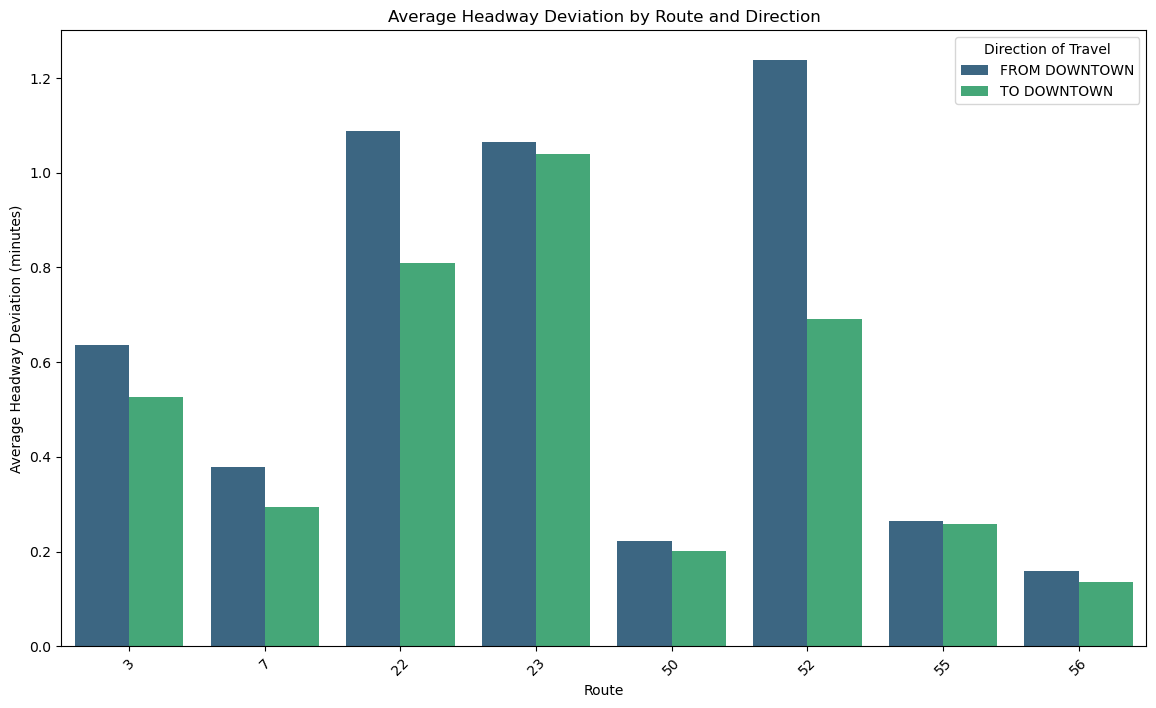

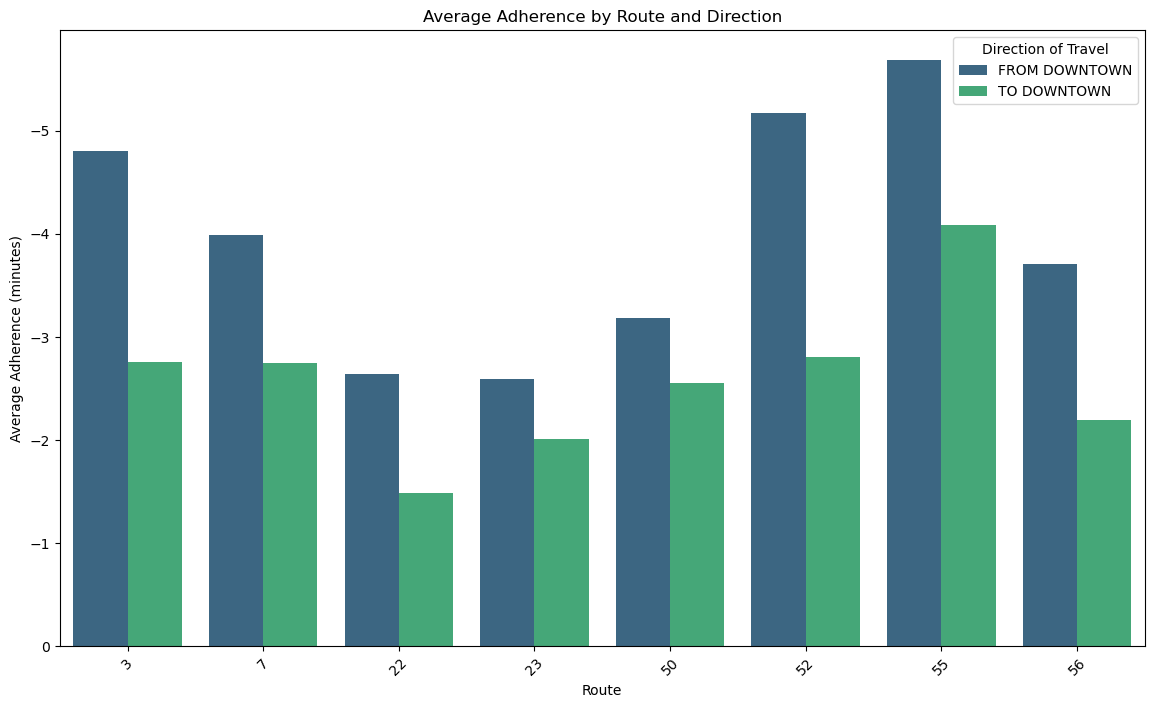

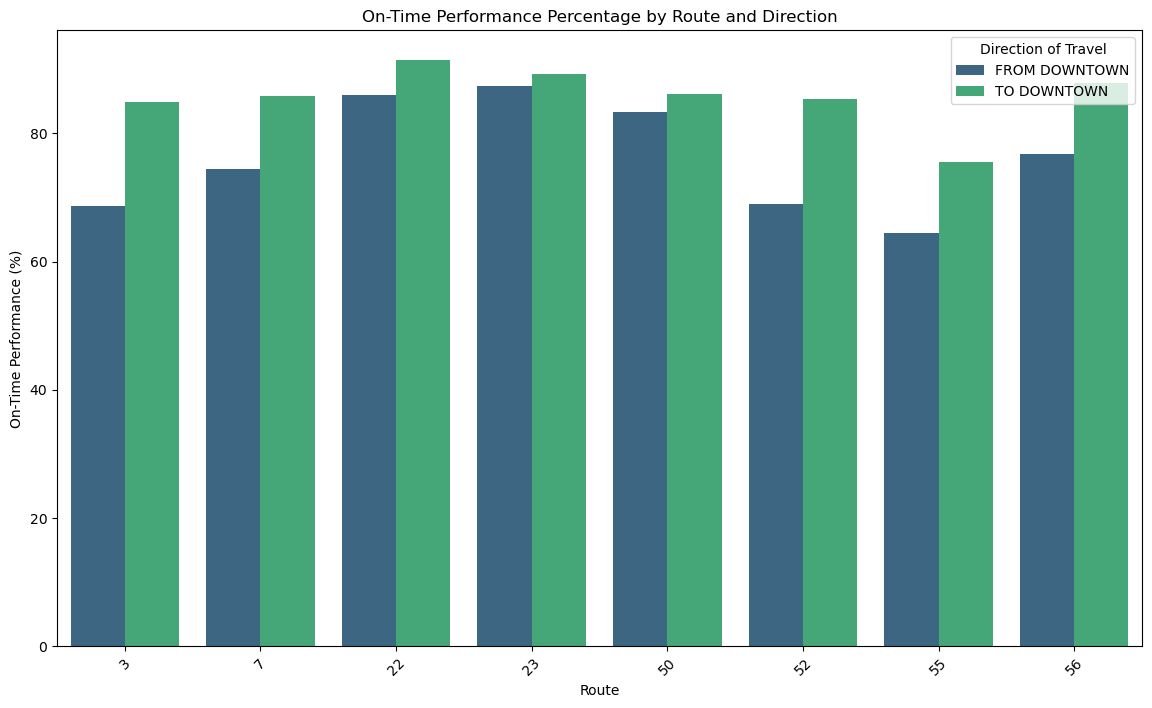

In [38]:
# Calculate average headway deviation and on-time performance
route_v_dir_performance_df = wego.groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).agg({
    'HDWY_DEV': 'mean', # avg headway dev for bus and direction combo
    'ADHERENCE': 'mean', # avg adherence for bus and direction combo
    'ADJUSTED_ONTIME_COUNT': 'sum', # number of times that bus and dir combo is on time 
    'ADJUSTED_LATE_COUNT': 'sum', # number of times that bus and dir combo is late
    'ADJUSTED_EARLY_COUNT': 'sum' # number of times that bus and dir combo is early 
}).reset_index()

# Calculate on-time percentage for each combination of route and direction
route_v_dir_performance_df['on_time_percentage'] = (
    route_v_dir_performance_df['ADJUSTED_ONTIME_COUNT'] /
    (route_v_dir_performance_df['ADJUSTED_ONTIME_COUNT'] +
     route_v_dir_performance_df['ADJUSTED_LATE_COUNT'] +
     route_v_dir_performance_df['ADJUSTED_EARLY_COUNT'])
) * 100

# route_v_dir_performance_df.head(20)

# Plot average headway deviation by route and direction
plt.figure(figsize=(14, 8))
sns.barplot(x='ROUTE_ABBR', y='HDWY_DEV', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
plt.title('Average Headway Deviation by Route and Direction')
plt.xlabel('Route')
plt.ylabel('Average Headway Deviation (minutes)')
plt.xticks(rotation=45)
plt.legend(title='Direction of Travel')
plt.show()

# Plot average adherence by route and direction
plt.figure(figsize=(14, 8))
sns.barplot(x='ROUTE_ABBR', y='ADHERENCE', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
plt.title('Average Adherence by Route and Direction')
plt.xlabel('Route')
plt.ylabel('Average Adherence (minutes)')
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.legend(title='Direction of Travel')
plt.show()

# Plot on-time performance percentage by route and direction
plt.figure(figsize=(14, 8))
sns.barplot(x='ROUTE_ABBR', y='on_time_percentage', hue='ROUTE_DIRECTION_NAME', data=route_v_dir_performance_df, palette='viridis')
plt.title('On-Time Performance Percentage by Route and Direction')
plt.xlabel('Route')
plt.ylabel('On-Time Performance (%)')
plt.xticks(rotation=45)
plt.legend(title='Direction of Travel')
plt.show()

3. How does time of day or day of week affect headway and on-time performance?


4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

5. Is there any relationship between lateness (ADHERENCE) and headway deviation?


## Stretch Goals ##

6. How much impact does being late or too spaced out at the first stop have downstream? 

7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more dwell time at the beginning of a trip lead to more stable headways (lower values for % headway deviation)? Do trips with longer **scheduled** layover time have more stable headway values?  

8. What is the relationship between distance or time traveled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has traveled?
